# Сборный проект-4

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.



## Описание данных





Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

Импортируем необходимые для работы библиотеки

In [1]:
# !pip install torchvision
!pip install --upgrade --no-cache-dir scikit-learn
!pip install catboost

In [2]:
import sklearn
print(sklearn.__version__)

1.6.1


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

Клонируем репозиторий с гитхаба

In [5]:
!git clone https://github.com/gala-vision/project_15.git
%cd project_15/notebooks


fatal: destination path 'project_15' already exists and is not an empty directory.
/content/project_15/notebooks


In [6]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
src_path = os.path.join(os.getcwd(), os.pardir, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
print("Путь к src:", src_path)


Путь к src: /content/project_15/notebooks/../src


In [7]:
from src.utils import information_data, aggregate_expert_ratings

## 1. Исследовательский анализ данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи нужно эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст исключим из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок объединим их в одну по критерию: оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4 и нормализуем. Если оценки экспертов нет, будем использовать оценку крауда из `fraction_confirmed`, она уже нормализована (от 0 до 1).

Модель будет возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная имеет значения от 0 до 1.


### `train_queries`

In [8]:
data_path = os.path.join(os.getcwd(), os.pardir, 'data')
train_images_path = os.path.join(data_path, 'train_images')
test_images_path = os.path.join(data_path, 'test_images')

In [9]:
train_queries = pd.read_csv(os.path.join(data_path, 'train_dataset.csv'))

print('Тренировочные запросы', end='\n\n')
information_data(train_queries)

Тренировочные запросы

Первые десять строк датафрейма:


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Описание данных:


,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Количество пропусков:


,0
image,0
query_id,0
query_text,0


Количество дубликатов:


0

### `test_queries`

In [10]:
test_queries = pd.read_csv(os.path.join(data_path, 'test_queries.csv'), sep='|', index_col=0)

print('Тестовые запросы', end='\n\n')
information_data(test_queries)

Тестовые запросы

Первые десять строк датафрейма:


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Описание данных:


,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


Количество пропусков:


,0
query_id,0
query_text,0
image,0


Количество дубликатов:


0

Обе выборки (обучающая и тестовая) имеют одинаковую структуру – содержат три столбца: идентификатор запроса (query_id), текст запроса (query_text) и название изображения (image).

Тестовая выборка:

Состоит из 500 записей, все значения уникальны.
Пропусков и дубликатов нет, что обеспечивает чистоту данных для тестирования модели.

Обучающая выборка:

Включает 5822 записи.
Количество уникальных значений немного отличается: имеется 1000 уникальных изображений и 977 уникальных запросов.
Также не содержит пропусков или дубликатов, что гарантирует корректное обучение модели.
Таким образом, обе выборки структурно идентичны и готовы для дальнейшей обработки при обучении и тестировании модели.

### `crowd_df`

In [11]:
column_names = ['image', 'query_id', 'fraction_confirmed', 'num_confirmed', 'num_rejected']
crowd_df = pd.read_csv(os.path.join(data_path, 'CrowdAnnotations.tsv'), sep='\t', names=column_names,
                       header=0)

print('Краудсорсинговые оценки', end='\n\n')
information_data(crowd_df)


Краудсорсинговые оценки

Первые десять строк датафрейма:


,image,query_id,fraction_confirmed,num_confirmed,num_rejected
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
7,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
8,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2436081047_bca044c1d3.jpg#2,0.000000,0,3


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               47829 non-null  object 
 1   query_id            47829 non-null  object 
 2   fraction_confirmed  47829 non-null  float64
 3   num_confirmed       47829 non-null  int64  
 4   num_rejected        47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Описание данных:


,fraction_confirmed,num_confirmed,num_rejected
count,47829.000000,47829.000000,47829.000000
mean,0.068766,0.208430,2.820214
std,0.207490,0.628775,0.656556
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


Количество пропусков:


,0
image,0
query_id,0
fraction_confirmed,0
num_confirmed,0
num_rejected,0


Количество дубликатов:


0

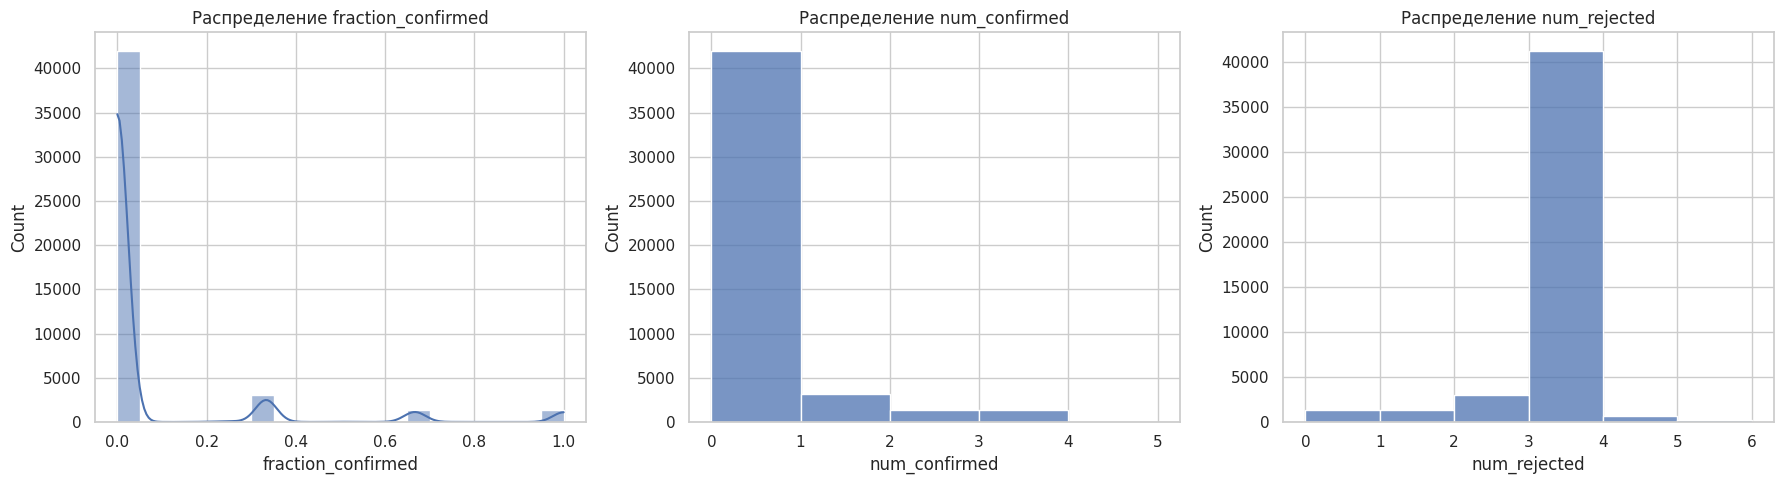

In [12]:
# Настройки графиков
sns.set(style="whitegrid")

# Графики для crowd_df
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(crowd_df['fraction_confirmed'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Распределение fraction_confirmed')

sns.histplot(crowd_df['num_confirmed'], bins=range(0, crowd_df['num_confirmed'].max() + 1), kde=False, ax=axes[1])
axes[1].set_title('Распределение num_confirmed')

sns.histplot(crowd_df['num_rejected'], bins=range(0, crowd_df['num_rejected'].max() + 1), kde=False, ax=axes[2])
axes[2].set_title('Распределение num_rejected')

plt.tight_layout()
plt.show()

### `expert_df`

In [13]:
column_names = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']
expert_df = pd.read_csv(os.path.join(data_path, 'ExpertAnnotations.tsv'), sep='\t', names=column_names, header=0)

print('Оценки экспертов', end='\n\n')
information_data(expert_df)

Оценки экспертов

Первые десять строк датафрейма:


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
5,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
7,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
8,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2
9,106490881_5a2dd9b7bd.jpg,2140182410_8e2a06fbda.jpg#2,2,2,2


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5821 non-null   object
 1   query_id  5821 non-null   object
 2   expert_1  5821 non-null   int64 
 3   expert_2  5821 non-null   int64 
 4   expert_3  5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

Описание данных:


,expert_1,expert_2,expert_3
count,5821.000000,5821.000000,5821.000000
mean,1.436695,1.624463,1.882151
std,0.787130,0.856256,0.904091
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Количество пропусков:


,0
image,0
query_id,0
expert_1,0
expert_2,0
expert_3,0


Количество дубликатов:


0

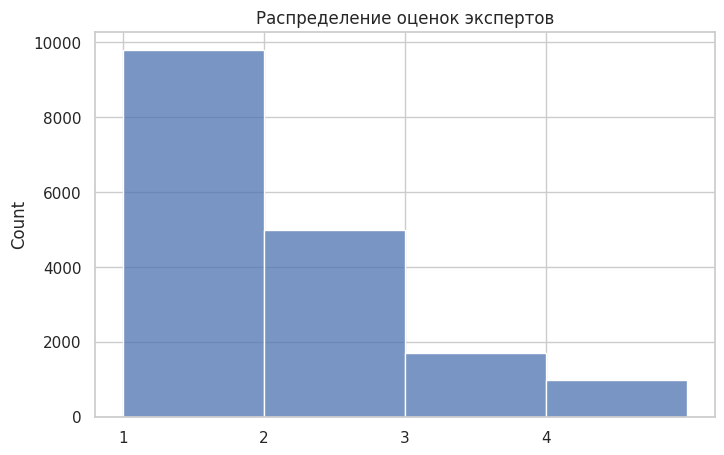

In [14]:
# Графики для expert_df
fig, ax = plt.subplots(figsize=(8, 5))

expert_scores = expert_df[['expert_1', 'expert_2', 'expert_3']].values.flatten()
sns.histplot(expert_scores, bins=range(1, expert_scores.max() + 2), kde=False)
ax.set_title('Распределение оценок экспертов')
ax.set_xticks(range(1, expert_scores.max() + 1))


Проверим связь между `query_id` и `image`:

Для этого разделим `query_id` по `#` и выделяем `image`.
Проверим, есть ли несовпадения между `image` в `query_id` и выделенным `image_from_query`.

И проверим полноту соответствий между изображениями и запросами: есть ли `image`, которые не встречаются в `query_id`, и наоборот.

In [15]:
crowd_df['image_from_query'] = crowd_df['query_id'].str.split('#').str[0]
expert_df['image_from_query'] = expert_df['query_id'].str.split('#').str[0]

# Проверяем, совпадают ли image и query_image
crowd_mismatch = crowd_df[crowd_df['image_from_query'] != crowd_df['image_from_query']]
expert_mismatch = expert_df[expert_df['image_from_query'] != expert_df['image_from_query']]

print(f'Несовпадения в CrowdAnnotations: {len(crowd_mismatch)}')
print(f'Несовпадения в ExpertAnnotations: {len(expert_mismatch)}')

# Проверяем, есть ли images, которых нет в query_id, и наоборот
unique_images_crowd = set(crowd_df['image_from_query'].unique())
unique_queries_crowd = set(crowd_df['image_from_query'].unique())
missing_images_crowd = unique_queries_crowd - unique_images_crowd

unique_images_expert = set(expert_df['image_from_query'].unique())
unique_queries_expert = set(expert_df['image_from_query'].unique())
missing_images_expert = unique_queries_expert - unique_images_expert

print(f'Изображений без query_id в CrowdAnnotations: {len(missing_images_crowd)}')
print(f'Изображений без query_id в ExpertAnnotations: {len(missing_images_expert)}')

Несовпадения в CrowdAnnotations: 0
Несовпадения в ExpertAnnotations: 0
Изображений без query_id в CrowdAnnotations: 0
Изображений без query_id в ExpertAnnotations: 0


Заключение по датасетам оценок:

В датасете краудсорсинговых оценок представлено 47 829 записей, каждая из которых содержит имя изображения, идентификатор описания и статистику подтверждения соответствия (доля подтверждений, число подтверждений и число отказов). Значения подтверждения в большинстве случаев равны нулю, что указывает на низкую согласованность оценок для большинства пар «изображение–описание».

В датасете экспертных оценок содержится 5 821 запись с тремя оценками от экспертов по шкале от 1 до 4. Экспертные оценки, в отличие от краудсорсинговых, характеризуются более высокой согласованностью и, в среднем, ниже значениями (близкими к минимальному порогу), что свидетельствует о строгом подходе экспертов к оценке соответствия.

Оба датасета не содержат пропусков и дубликатов, что гарантирует корректность данных для последующего анализа и обучения модели.

Несовпадений нет (все `image` правильно извлекаются из `query_id`).

Все изображения имеют `query_id`, пропусков нет.
Вывод: данные корректны, `image` и `query_id` связаны ожидаемым образом.

### `final_df`

Агрегируем оценки соответствия описаний изображениям следующим образом:

Агрегация оценок:

Для пар с экспертными оценками:

Рассчитаем итоговую оценку по голосованию большинства, нормализуем её.
Рассчитаем итоговую оценку как

$ 0.7 × $ `expert_norm`$ + 0.3 × $ `fraction_confirmed`

Для пар без экспертных оценок используем крауд-оценку

Объединение датасетов:

Соберем итоговую таблицу, где для каждой пары «изображение–описание» будет указана итоговая оценка. При этом, если требуется, можно добавить отдельные колонки для экспертных и крауд оценок как дополнительные признаки, но итоговая агрегированная оценка должна стать целевой переменной.

In [16]:
# 1. Агрегируем экспертные оценки
expert_df['expert_score'] = expert_df.apply(aggregate_expert_ratings, axis=1)
# expert_df.drop(columns=['expert_1', 'expert_2', 'expert_3'], inplace=True)  # Удаляем исходные колонки
expert_df.dropna(subset=['expert_score'], inplace=True)  # Убираем строки с противоречивыми оценками

In [17]:
# 2. Нормализуем экспертные оценки (min=1, max=4 -> от 0 до 1)
expert_df['expert_score_norm'] = (expert_df['expert_score'] - 1) / 3

In [18]:
# 3. Объединяем датасеты
merged_df = pd.merge(expert_df, crowd_df, on=['image', 'query_id'], how='left')

In [19]:
# 4. Если есть обе оценки - берем взвешенное среднее
mask = (~merged_df['expert_score_norm'].isna()) & (~merged_df['fraction_confirmed'].isna())
merged_df.loc[mask, 'final_score'] = (
    0.7 * merged_df.loc[mask, 'expert_score_norm'] + 0.3 * merged_df.loc[mask, 'fraction_confirmed']
)

In [20]:
# 5. Если есть только одна из оценок, используем её
merged_df['final_score'] = merged_df['final_score'].combine_first(
    merged_df['expert_score_norm'].combine_first(merged_df['fraction_confirmed'])
)

In [21]:
# 6. Оставляем только нужные столбцы
final_df = merged_df[['image', 'query_id', 'final_score']]

Посмотрим на распределение таргета на гистограмме

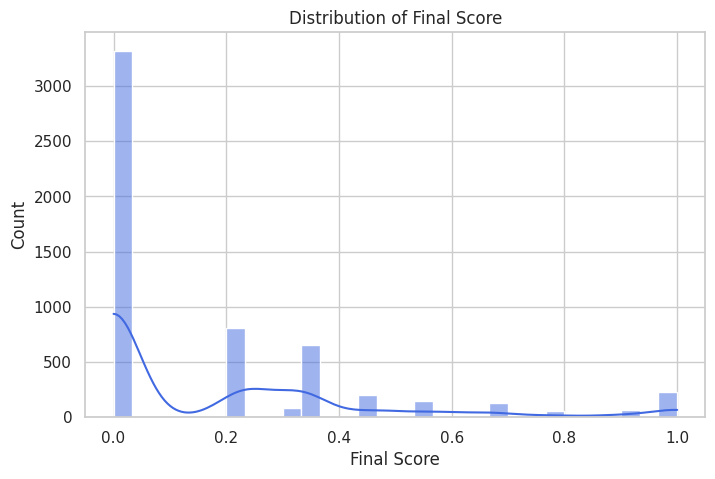

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(final_df['final_score'], bins=30, kde=True, color='royalblue')
plt.xlabel('Final Score')
plt.ylabel('Count')
plt.title('Distribution of Final Score')
plt.grid(True)
plt.show()


In [23]:
information_data(final_df)

Первые десять строк датафрейма:


,image,query_id,final_score
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000
5,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,0.000000
6,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.000000
7,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,0.000000
8,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,0.333333
9,106490881_5a2dd9b7bd.jpg,2140182410_8e2a06fbda.jpg#2,0.333333


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5695 entries, 0 to 5694
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5695 non-null   object 
 1   query_id     5695 non-null   object 
 2   final_score  5695 non-null   float64
dtypes: float64(1), object(2)
memory usage: 133.6+ KB


None

Описание данных:


,final_score
count,5695.000000
mean,0.180187
std,0.265912
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,1.000000


Количество пропусков:


,0
image,0
query_id,0
final_score,0


Количество дубликатов:


0

Итоговый датасет содержит 5695 записей, каждая из которых представляет собой пару изображение-описание с оценкой соответствия (final_score), рассчитанной на основе экспертных и краудсорсинговых оценок.

Общие характеристики датасета:
- Всего строк: 5695
- Количество уникальных изображений: 1000
- Количество уникальных описаний: 977
- Количество пропущенных значений: 0
- Количество дубликатов: 0

Распределение таргета (final_score)
- Средняя оценка: 0.18
- Медиана: 0.00 (то есть большинство описаний слабо соответствуют изображениям)
- Стандартное отклонение: 0.27
- Минимальное значение: 0.00
- Максимальное значение: 1.00
- 25-й процентиль: 0.00
- 75-й процентиль: 0.33

Можно видеть, что медиана равна 0, а 75% значений ниже 0.33, что говорит о том, что значительная часть пар "изображение-описание" была оценена низко. Однако есть небольшое количество примеров с высоким соответствием.

Качество соответствия изображений и описаний

Примеры данных показывают, что некоторые описания полностью не соответствуют изображениям (оценка 0), в то время как другие имеют частичное или полное совпадение (0.33 и выше). Оставим пока в таком виде: обучение на отрицательных примерах также важно, потому что модель должна не только определять соответствие изображения и текста, но и понимать, когда описание не соответствует изображению. Это позволит ей лучше различать релевантные и нерелевантные пары. В дальнейшем можно будет поэспериментировать с порогами классов и понаблюдать, как будет меняться метрика.

Следующие шаги

- Очистить датасет от изображений, содержащих несовершеннолетних, используя текстовые описания и (опционально) предобученные модели.
- Провести финальный анализ очищенного датасета перед векторизацией данных и обучением модели.

Посмотрим несколько изображений и описаний к ним

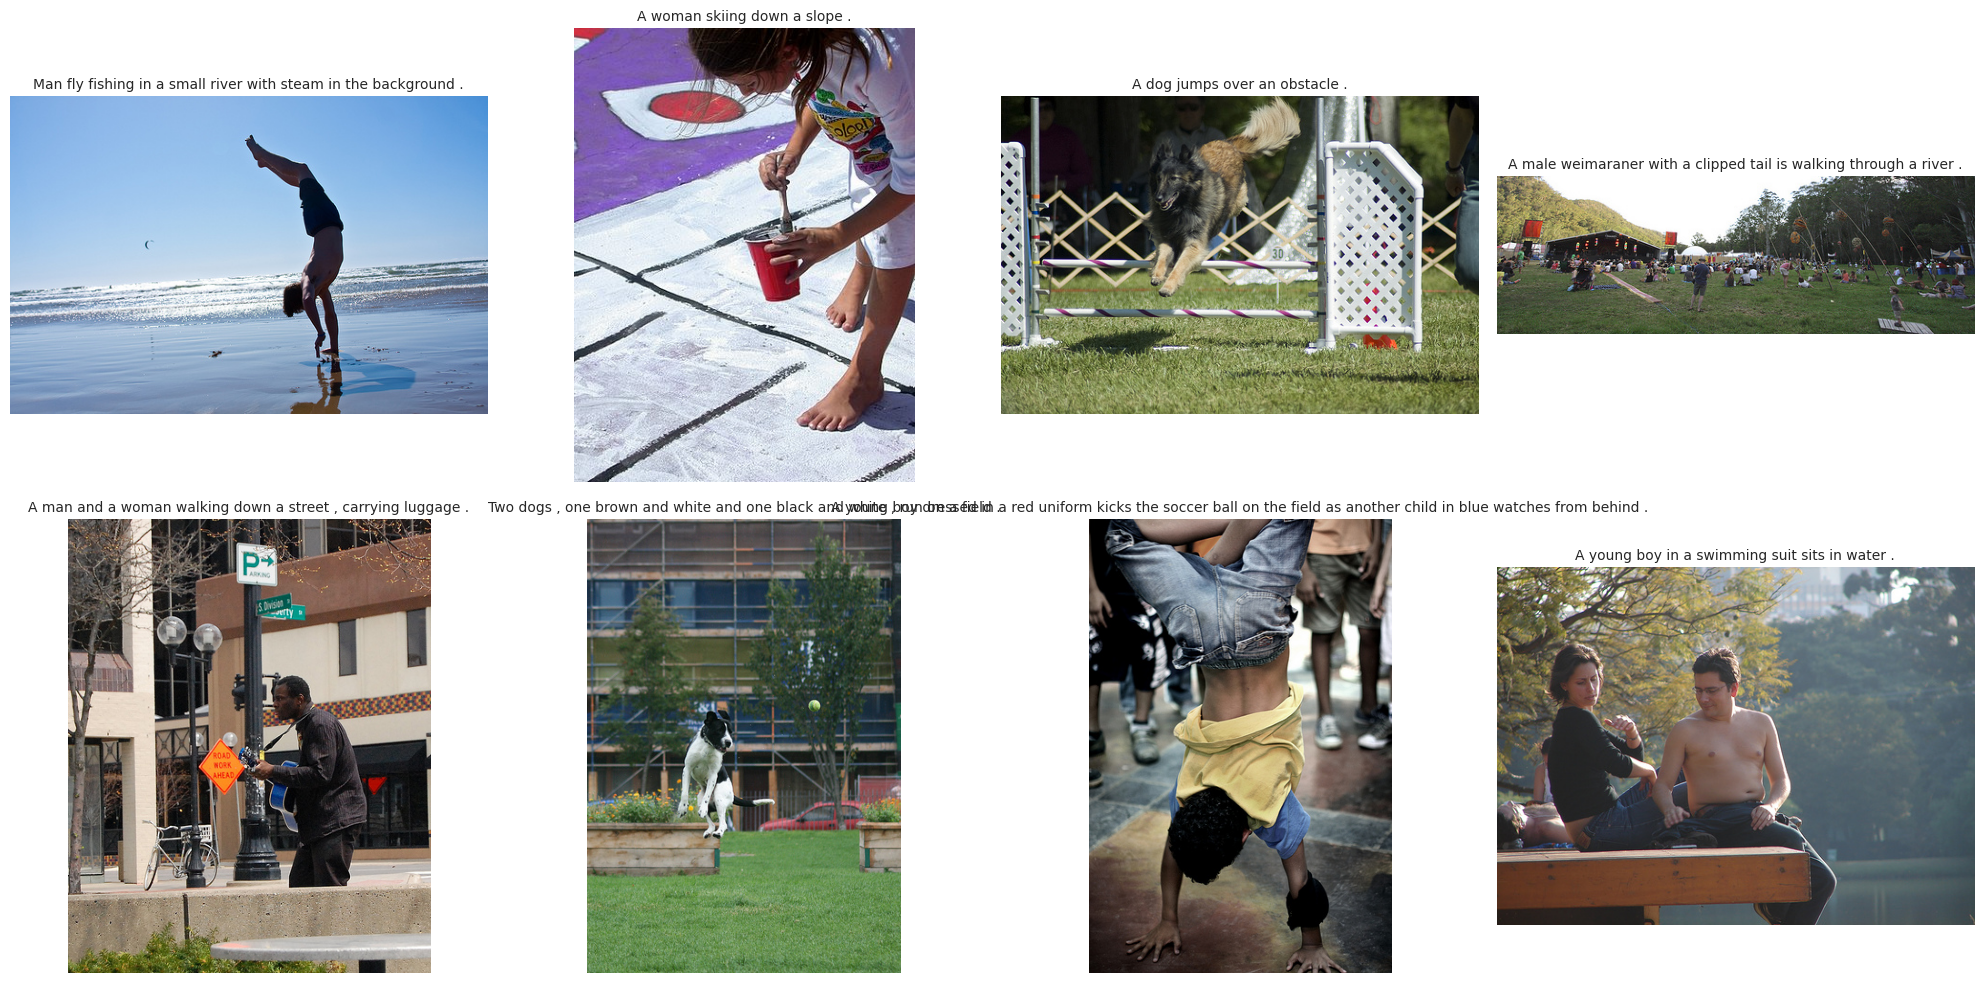

In [24]:
sample = train_queries.sample(8, random_state=1000)  # Берем 8 случайных примеров

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, row in enumerate(sample.itertuples()):
    image_path = os.path.join(train_images_path, row.image)

    try:
        image = Image.open(image_path)
        axes[idx].imshow(image)
        axes[idx].axis("off")
        axes[idx].set_title(row.query_text, fontsize=10)
    except FileNotFoundError:
        print(f"Файл {row.image} не найден.")
        axes[idx].axis("off")

plt.tight_layout()
plt.show()

## 2. Проверка данных

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, удалим из обучающей выборки.

Анализ текстовых описаний

Если в описании явно упоминается ребенок (например, "child", "kid", "baby", "boy", "girl" и т. д.), то, скорее всего, на картинке изображен несовершеннолетний.

Используем NLP (анализ текста) для поиска таких слов в query_text.
Если описание содержит слова, связанные с детьми, то удаляем эту запись.

In [25]:
# добавим в итоговый датасет текстовое описание изображения и проверим на дубликаты
final_df = final_df.merge(train_queries, on=['query_id', 'image'], how='left')
print(f'Количество дубликатов в итоговом датарейме final_df_merged: {final_df.duplicated().sum()}')

Количество дубликатов в итоговом датарейме final_df_merged: 0


In [26]:
# проверяем результат
print(final_df.info())
display(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5695 entries, 0 to 5694
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5695 non-null   object 
 1   query_id     5695 non-null   object 
 2   final_score  5695 non-null   float64
 3   query_text   5695 non-null   object 
dtypes: float64(1), object(3)
memory usage: 178.1+ KB
None


,image,query_id,final_score,query_text
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000,A girl wearing a yellow shirt and sunglasses s...
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000,A man sleeps under a blanket on a city street .
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333,A woman plays with long red ribbons in an empt...
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000,Chinese market street in the winter time .
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,A soccer ball is above the head of a man weari...


In [27]:
child_keywords = ["child", "kid", "baby", "boy", "girl", "toddler", "infant", "teen", "young", "little", "small"]

mask = final_df['query_text'].str.contains('|'.join(child_keywords), case=False, na=False)

cleaned_df = final_df[~mask]

print(f"Удалено записей: {final_df.shape[0] - cleaned_df.shape[0]}")


Удалено записей: 1784


In [28]:
information_data(cleaned_df)

Первые десять строк датафрейма:


,image,query_id,final_score,query_text
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000,A man sleeps under a blanket on a city street .
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333,A woman plays with long red ribbons in an empt...
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000,Chinese market street in the winter time .
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,A soccer ball is above the head of a man weari...
6,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.000000,A man and woman look back at the camera while ...
7,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,0.000000,A white dog jumps to catch a blue ball in a li...
10,106490881_5a2dd9b7bd.jpg,2398605966_1d0c9e6a20.jpg#2,0.000000,Two long-haired puppy dogs have a romp in the ...
12,106490881_5a2dd9b7bd.jpg,3119076670_64b5340530.jpg#2,0.000000,Snowboarder in the air performing a stunt .
13,106490881_5a2dd9b7bd.jpg,317488612_70ac35493b.jpg#2,0.000000,A dog runs through the deep snow .
14,106490881_5a2dd9b7bd.jpg,493621130_152bdd4e91.jpg#2,0.000000,A dog wearing a collar jumping from a platform .


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 3911 entries, 1 to 5694
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        3911 non-null   object 
 1   query_id     3911 non-null   object 
 2   final_score  3911 non-null   float64
 3   query_text   3911 non-null   object 
dtypes: float64(1), object(3)
memory usage: 152.8+ KB


None

Описание данных:


,final_score
count,3911.000000
mean,0.195601
std,0.278768
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,1.000000


Количество пропусков:


,0
image,0
query_id,0
final_score,0
query_text,0


Количество дубликатов:


0

Проверим, как прошло очищение данных:

In [29]:
# Список ключевых слов, которые могут указывать на присутствие детей
child_keywords = ["child", "baby", "toddler", "kid", "infant", "boy", "girl",
                  "young boy", "young girl", "little boy", "little girl",
                  "children", "kids", "school"]

# Приводим query_text к нижнему регистру и проверяем наличие ключевых слов
mask_children = cleaned_df['query_text'].str.lower().str.contains('|'.join(child_keywords), na=False)

# Отбираем записи, где могут быть дети
potential_child_images = cleaned_df[mask_children]

# Смотрим примеры
display(potential_child_images.head())

,image,query_id,final_score,query_text


In [30]:
final_df = cleaned_df

Проверим, сколько уникальных теккстов и изображений в итоговом датафрейме. Будем векторизовать и токенизировать только уникальные, изображения и тексты независимо друг от друга, а затем объединим полученные данные.

In [31]:
print('Количество уникальных текстов в final_df', final_df['query_text'].nunique())
print('Количество уникальных изображений в final_df', final_df['image'].nunique())

Количество уникальных текстов в final_df 642
Количество уникальных изображений в final_df 988


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Для представления изображений в числовом формате будем использовать **ResNet-18** – предобученную сверточную нейросеть. Уберем последний полносвязный слой, чтобы получить **512-мерные векторы**, которые отражают главные особенности изображения, и впоследствии использовать полученные векторы в качестве признаков для дальнейшего обучения модели.

- Загрузим предобученную `ResNet-18`.
- Уберем последний слой (`FC`), чтобы получать эмбеддинги.
- Применим `torchvision.transforms` для предобработки изображений.
- Преобразуем каждое изображение в вектор длины **512**.
- Добавим полученные векторы в `final_df_with_vectors`.


In [32]:
unique_images = final_df['image'].drop_duplicates()  # Оставляем только уникальные изображения

In [33]:
# Загружаем предобученную модель ResNet-18
model = models.resnet18(pretrained=True)

# Убираем последний слой (полносвязный)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# Преобразование изображений в тензоры
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер изображения
    transforms.ToTensor(),          # Преобразуем в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

# Функция для векторизации изображений
def extract_features(image_path, model):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0)  # Добавляем размерность batch
        with torch.no_grad():
            features = model(image)  # Получаем векторное представление
        return features.squeeze().numpy()  # Преобразуем в numpy
    except Exception as e:
        print(f"Ошибка с файлом {image_path}: {e}")

# Векторизуем изображения из cleaned_df
image_vectors = {}
for img_name in unique_images['image']:
    img_path = os.path.join(train_images_path, img_name)
    if os.path.exists(img_path):
        image_vectors[img_name] = extract_features(img_path, model)

# Преобразуем в DataFrame
image_vectors_df = pd.DataFrame.from_dict(image_vectors, orient='index')
image_vectors_df.reset_index(inplace=True)
image_vectors_df.rename(columns={'index': 'image'}, inplace=True)

final_df_with_vectors = final_df.merge(image_vectors_df, on='image', how='left')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Проверяем размерность векторов
print(f"Количество векторизованных изображений: {len(image_vectors)}")

display(final_df_with_vectors.sample())

Количество векторизованных изображений: 988


,image,query_id,final_score,query_text,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
2027,3119076670_64b5340530.jpg,3119076670_64b5340530.jpg#2,1.0,Snowboarder in the air performing a stunt .,0.476465,0.76695,0.103135,0.496535,0.295093,0.058747,...,0.066174,0.550599,0.171468,0.17744,1.162852,1.877513,1.046368,0.820217,0.964109,1.214681


In [35]:
print('Общая информация о датафрейме:', end='\n\n')
final_df_with_vectors.info()
print()
print(f'Количество дубликатов:', final_df_with_vectors.duplicated().sum(), end='\n\n')
print(f'Количество пропусков: {final_df_with_vectors.isna().sum()}')

Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Columns: 516 entries, image to 511
dtypes: float32(512), float64(1), object(3)
memory usage: 7.8+ MB

Количество дубликатов: 0

Количество пропусков: image          0
query_id       0
final_score    0
query_text     0
0              0
              ..
507            0
508            0
509            0
510            0
511            0
Length: 516, dtype: int64


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [36]:
unique_queries = final_df['query_text'].drop_duplicates()

In [41]:
# Загружаем токенизатор и модель BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # Отключаем градиенты

# Функция для векторизации текста
def extract_text_features(text):
    """Токенизирует текст, прогоняет через BERT и возвращает средний эмбеддинг."""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Усредняем по всем токенам
    return embeddings.squeeze().numpy()  # Преобразуем в numpy-массив

# Векторизуем текстовые описания
text_vectors = unique_queries.apply(extract_text_features)


In [42]:
# Преобразуем в DataFrame и добавляем обратно query_text
text_vectors_df = pd.DataFrame(text_vectors.tolist(), index=unique_queries.index)
text_vectors_df.columns = [f"text_feat_{i}" for i in range(text_vectors_df.shape[1])]

# Добавляем `query_text` обратно в DataFrame перед объединением
text_vectors_df["query_text"] = unique_queries.values


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [43]:
df = final_df_with_vectors.merge(text_vectors_df, on="query_text", how="left")

# Проверяем размер итогового датасета
print(df.shape)
display(df.head())

(3911, 1284)


,image,query_id,final_score,query_text,0,1,2,3,4,5,...,text_feat_758,text_feat_759,text_feat_760,text_feat_761,text_feat_762,text_feat_763,text_feat_764,text_feat_765,text_feat_766,text_feat_767
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000,A man sleeps under a blanket on a city street .,0.802746,3.356913,2.514861,0.942548,1.508469,2.346693,...,0.199519,-0.168477,-0.130826,0.050839,0.137441,0.234321,0.040068,-0.390364,0.070866,0.154538
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333,A woman plays with long red ribbons in an empt...,0.802746,3.356913,2.514861,0.942548,1.508469,2.346693,...,-0.083036,0.299615,-0.275095,0.257130,0.171890,0.109804,0.300465,-0.337860,-0.231128,0.203774
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000,Chinese market street in the winter time .,0.802746,3.356913,2.514861,0.942548,1.508469,2.346693,...,0.215019,-0.496596,0.196086,0.023435,0.058630,-0.225643,-0.428861,-0.376989,0.101353,-0.115983
3,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,A soccer ball is above the head of a man weari...,0.802746,3.356913,2.514861,0.942548,1.508469,2.346693,...,-0.414029,-0.054176,-0.092430,0.010714,0.187050,0.057156,-0.019266,0.152452,0.159650,0.040818
4,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.000000,A man and woman look back at the camera while ...,0.802746,3.356913,2.514861,0.942548,1.508469,2.346693,...,-0.063104,-0.258255,-0.196546,0.046043,-0.201219,0.353375,0.062098,-0.510358,0.055820,-0.231715


Проверим полученные данные:

In [44]:
print('Количество пропусков в итоговом датасете')
print(df.isna().sum().sum())
print(df.isna().sum().sort_values(ascending=False).head(20))


0
image            0
text_feat_287    0
text_feat_345    0
text_feat_344    0
text_feat_343    0
text_feat_342    0
text_feat_341    0
text_feat_340    0
text_feat_339    0
text_feat_338    0
text_feat_337    0
text_feat_336    0
text_feat_335    0
text_feat_334    0
text_feat_333    0
text_feat_332    0
text_feat_331    0
text_feat_330    0
text_feat_329    0
text_feat_346    0
dtype: int64


In [49]:
print('Количество дубликатов по столбцу query_text в финальном датасете', df['query_text'].duplicated().sum())

Количество дубликатов по столбцу query_text в финальном датасете 3269


In [46]:
print(f"Уникальных query_text в финальном датасете: {df['query_text'].nunique()}")
print(f"Уникальных query_text в text_vectors_df: {df['query_text'].nunique()}")


Уникальных query_text в финальном датасете: 642
Уникальных query_text в text_vectors_df: 642


In [47]:
print(df.duplicated(subset=["query_text", "image"]).sum())

0


Данные векторизованы и корректно объединены. Можем переходить к обучению моделей.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Для исключения попадания изображения и в обучающую, и в тестовую выборки используем класс [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

В проекте будем обучать линейную регрессию и полносвязную нейронную сеть.

В качестве метрики возьмем среднеквадратичную ошибку `RMSE`: метрика показывает, насколько в среднем модель ошибается в предсказании final_score. Чем ниже значение RMSE, тем точнее модель. `RMSE` более чувствителен к большим ошибкам, так как квадратичная функция штрафует большие отклонения сильнее.
Для нашей задачи `RMSE` лучше, потому что мы не просто хотим минимизировать ошибки, но и сильно штрафовать случаи, когда модель предсказывает совсем плохо (например, если соответствие должно быть высоким, а модель даёт очень низкий балл).

### Линейная регрессия

In [51]:
# Определяем наш GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

# Разбиваем данные с учетом группировки по 'image'
train_indices, test_indices = next(gss.split(
    X=df.drop(columns=['final_score']),  # Убираем таргет
    y=df['final_score'],  # Целевая переменная
    groups=df['image']  # Группируем по изображениям
))

# Формируем тренировочную и тестовую выборки
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

# Проверяем размеры
print(f"Размер train_df: {train_df.shape}")
print(f"Размер test_df: {test_df.shape}")

# Проверяем, что нет пересечения изображений между train и test
common_images = set(train_df['image']).intersection(set(test_df['image']))
print(f"Общее количество изображений в train: {train_df['image'].nunique()}")
print(f"Общее количество изображений в test: {test_df['image'].nunique()}")
print(f"Количество одинаковых изображений в train и test: {len(common_images)}")


Размер train_df: (2751, 1284)
Размер test_df: (1160, 1284)
Общее количество изображений в train: 691
Общее количество изображений в test: 297
Количество одинаковых изображений в train и test: 0


In [52]:
# Определяем признаки (X) и целевую переменную (y)
X_train = train_df.drop(columns=['image', 'query_id', 'query_text', 'final_score'])
y_train = train_df['final_score']

X_test = test_df.drop(columns=['image', 'query_id', 'query_text', 'final_score'])
y_test = test_df['final_score']

# Масштабируем признаки

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [54]:
# Обучаем линейную регрессию
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Делаем предсказания
y_pred = model.predict(X_test_scaled)

# Оцениваем качество модели
rmse = mean_squared_error(y_test, y_pred)

print(f"\nRMSE Linreg: {rmse:.4f}")

RMSE: 0.1796
R²: -1.4259


RMSE = 0.1796 — ошибка на тесте, относительно невысокая, но пока не ясно, насколько она мала в контексте задачи. Обучим полносвязную нейронную сеть.

### Нейронная сеть

In [57]:
# 1. Подготовка данных
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. Определяем архитектуру нейросети
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Выход один — предсказание финального score
        )

    def forward(self, x):
        return self.model(x)

# 3. Создаём модель
input_dim = X_train.shape[1]
model = MLP(input_dim)
criterion = nn.MSELoss()  # Функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор

# 4. Обучаем модель
num_epochs = 20  # Можно настроить
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

# 5. Делаем предсказания
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# 6. Оцениваем качество
y_pred_nn = y_pred_tensor.numpy().flatten()
rmse_nn = mean_squared_error(y_test, y_pred_nn)

print(f"\nRMSE нейросети: {rmse_nn:.4f}")


Epoch 1/20, Loss: 0.0696
Epoch 2/20, Loss: 0.0522
Epoch 3/20, Loss: 0.0419
Epoch 4/20, Loss: 0.0370
Epoch 5/20, Loss: 0.0312
Epoch 6/20, Loss: 0.0265
Epoch 7/20, Loss: 0.0243
Epoch 8/20, Loss: 0.0222
Epoch 9/20, Loss: 0.0206
Epoch 10/20, Loss: 0.0180
Epoch 11/20, Loss: 0.0173
Epoch 12/20, Loss: 0.0134
Epoch 13/20, Loss: 0.0124
Epoch 14/20, Loss: 0.0119
Epoch 15/20, Loss: 0.0104
Epoch 16/20, Loss: 0.0111
Epoch 17/20, Loss: 0.0104
Epoch 18/20, Loss: 0.0095
Epoch 19/20, Loss: 0.0089
Epoch 20/20, Loss: 0.0093
RMSE нейросети: 0.0547


### Catboost

In [63]:
# Инициализируем CatBoost
model_cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    verbose=100,
    random_seed=42
)

# Обучаем модель
model_cb.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Делаем предсказания
y_pred_cb = model_cb.predict(X_test)

# Оцениваем качество модели
rmse_cb = mean_squared_error(y_test, y_pred_cb)

print(f"\nRMSE CatBoost: {rmse_cb:.4f}")


0:	learn: 0.2798329	test: 0.2708187	best: 0.2708187 (0)	total: 930ms	remaining: 7m 43s
100:	learn: 0.2133988	test: 0.2481709	best: 0.2480526 (93)	total: 42.9s	remaining: 2m 49s
200:	learn: 0.1750207	test: 0.2421731	best: 0.2421731 (200)	total: 1m 18s	remaining: 1m 56s
300:	learn: 0.1418686	test: 0.2397049	best: 0.2397049 (300)	total: 1m 54s	remaining: 1m 15s
400:	learn: 0.1186343	test: 0.2377547	best: 0.2377547 (400)	total: 2m 30s	remaining: 37s
499:	learn: 0.1002682	test: 0.2369478	best: 0.2369075 (498)	total: 3m 6s	remaining: 0us

bestTest = 0.23690753
bestIteration = 498

Shrink model to first 499 iterations.
RMSE CatBoost: 0.0547


Нейронная сеть и CatBoost показывют метрику, совпадающую до 4 знаков после точки. Посмотрим распределение предсказаний на графике

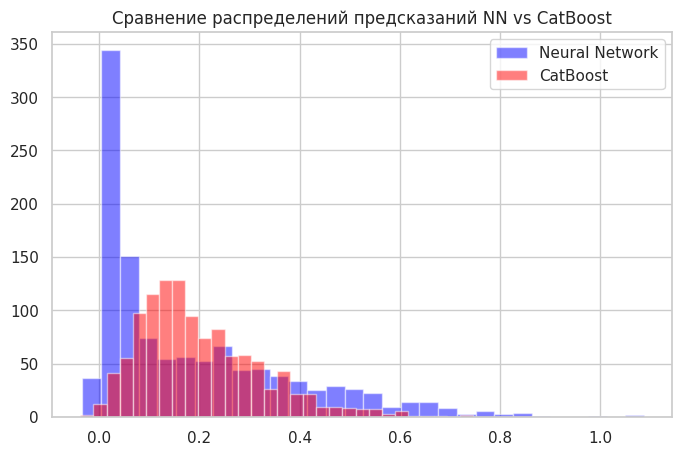

In [69]:


plt.figure(figsize=(8, 5))
plt.hist(y_pred_nn, bins=30, alpha=0.5, label="Neural Network", color="blue")
plt.hist(y_pred_cb, bins=30, alpha=0.5, label="CatBoost", color="red")
plt.legend()
plt.title("Сравнение распределений предсказаний NN vs CatBoost")
plt.show()


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска